PURCHASE INCIDENCE MODEL

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

In [2]:
WeekMapDF = pd.read_excel('DFs\\WeekMapDF.xlsx')
CustDemographicDF = pd.read_excel('DFs\\CustDemographicDF.xlsx')
StoreTransactionsDF = pd.read_excel('DFs\\StoreTransactionsDF.xlsx')
CustTransactionsDF = pd.read_excel('DFs\\CustTransactionsDF.xlsx')
BeerTransactionsDF = pd.read_excel('DFs\\BeerTransactionsDF.xlsx')

StoreTransactionsDF = StoreTransactionsDF[StoreTransactionsDF['IRI_KEY'] == 257871]
CustTransactionsDF = CustTransactionsDF[CustTransactionsDF['IRI_KEY'] == 257871]
BeerTransactionsDF = BeerTransactionsDF[BeerTransactionsDF['IRI_KEY'] == 257871]

In [3]:
# Promo score
StoreTransactionsDF['FEATURE_SCORE'] = (StoreTransactionsDF['FEATURE'] > 0).astype(int)
StoreTransactionsDF['DISPLAY_SCORE'] = (StoreTransactionsDF['DISPLAY'] > 0).astype(int)
StoreTransactionsDF['PRICE_REDUCTION_SCORE'] = (StoreTransactionsDF['PRICE_REDUCTION'] > 0).astype(int)
promo_summary = StoreTransactionsDF.groupby(['IRI_KEY', 'WEEK_DATE'], as_index=False).agg({
    'FEATURE_SCORE': 'sum',
    'DISPLAY_SCORE': 'sum',
    'PRICE_REDUCTION_SCORE': 'sum',
})

promo_summary["PROMO_SCORE"] = promo_summary["FEATURE_SCORE"] + promo_summary["DISPLAY_SCORE"] + promo_summary["PRICE_REDUCTION_SCORE"]

promo_summary = promo_summary.sort_values("WEEK_DATE")

# Create lagged variables (1-week lag)
promo_summary["FEATURE_LAG1"] = promo_summary["FEATURE_SCORE"].shift(1)
promo_summary["DISPLAY_LAG1"] = promo_summary["DISPLAY_SCORE"].shift(1)
promo_summary["PRICE_REDUCTION_LAG1"] = promo_summary["PRICE_REDUCTION_SCORE"].shift(1)

promo_summary = promo_summary.fillna(0)


df = (CustTransactionsDF[['PANID', 'WEEK_DATE', 'IRI_KEY', 'MINUTE', 'TRIP_COST']]
    .merge(BeerTransactionsDF[['PANID', 'WEEK_DATE',  'IRI_KEY', 'MINUTE', 'BEER_PURCHASED', 'IS_HOLIDAY']], on=['PANID', 'WEEK_DATE', 'IRI_KEY', 'MINUTE'], how='left')
    .merge(WeekMapDF[['WEEK_DATE', 'SEASON']], on='WEEK_DATE', how='left')
    .merge(CustDemographicDF[['PANID', 'INCOME', 'RESIDENCE_TYPE', 'AGE_HH', 'EDU_HH', 'OCU_HH', 'RACE']], on='PANID', how='left')
    .merge(promo_summary, on=['IRI_KEY', 'WEEK_DATE'], how='left'))

# Adstock effect
decay = 0.7
df["FEATURE_ADSTOCK"] = df["FEATURE_SCORE"]*decay + df["FEATURE_LAG1"]*(1-decay)
df["DISPLAY_ADSTOCK"] = df["DISPLAY_SCORE"]*decay + df["DISPLAY_LAG1"]*(1-decay)
df["PRICE_ADSTOCK"]   = df["PRICE_REDUCTION_SCORE"]*decay + df["PRICE_REDUCTION_LAG1"]*(1-decay)

# Log-transform TRIP_COST
df["TRIP_COST"] = np.log1p(df["TRIP_COST"])

# Handling missing values
nan_columns = ['BEER_PURCHASED', 'IS_HOLIDAY', 'FEATURE_SCORE', 'DISPLAY_SCORE', 'PRICE_REDUCTION_SCORE', 'PROMO_SCORE']
df[nan_columns] = df[nan_columns].fillna(0).astype(int)

# Compute day of week
df['DAY_OF_WEEK'] = df['MINUTE'].floordiv(1440)

# Collapse INCOME into 3 bins
def collapse_income(x):
    if x <= 4:   # lowest 4 categories
        return "Low"
    elif x <= 7: # lower middle categories
        return "LowerMid"
    elif x <= 10: # upper middle categories
        return "UpperMid"
    else:        # top income groups
        return "High"

df["INCOME"] = df["INCOME"].apply(collapse_income)

# Collapse AGE_HH into 3 bins
def collapse_age(x):
    if x <= 2:     # young (codes 1–3)
        return "Young"
    elif x <= 4:   # middle-aged (codes 4–5)
        return "Middle"
    else:          # older (codes 6–7)
        return "Older"

df["AGE_HH"] = df["AGE_HH"].apply(collapse_age)


# Beer frequency
cust_loyalty = df.groupby("PANID").agg(
    beer_trips=("BEER_PURCHASED", "sum"),
    total_trips=("WEEK_DATE", "count")
).reset_index()

cust_loyalty["FREQUENCY_RATIO"] = cust_loyalty["beer_trips"] / cust_loyalty["total_trips"]

def frequency_category(ratio):
    if ratio < 0.2:
        return "Rare"
    elif ratio < 0.5:
        return "Frequent"
    else:
        return "Loyal"

cust_loyalty["FREQUENCY"] = cust_loyalty["FREQUENCY_RATIO"].apply(frequency_category)

df = df.merge(cust_loyalty[["PANID", "FREQUENCY"]], on="PANID", how="left")

df

,PANID,WEEK_DATE,IRI_KEY,MINUTE,TRIP_COST,BEER_PURCHASED,IS_HOLIDAY,SEASON,INCOME,RESIDENCE_TYPE,AGE_HH,EDU_HH,OCU_HH,RACE,FEATURE_SCORE,DISPLAY_SCORE,PRICE_REDUCTION_SCORE,PROMO_SCORE,FEATURE_LAG1,DISPLAY_LAG1,PRICE_REDUCTION_LAG1,FEATURE_ADSTOCK,DISPLAY_ADSTOCK,PRICE_ADSTOCK,DAY_OF_WEEK,FREQUENCY
0,3100248,2008-12-29,257871,9649,3.559590,0,0,Winter,UpperMid,2,Middle,3,2,1,7,26,47,80,0.0,0.0,0.0,4.9,18.2,32.9,6,Loyal
1,3100248,2009-02-02,257871,7935,3.696788,0,0,Winter,UpperMid,2,Middle,3,2,1,13,34,41,88,9.0,30.0,36.0,11.8,32.8,39.5,5,Loyal
2,3100248,2009-02-09,257871,6607,3.479648,1,1,Winter,UpperMid,2,Middle,3,2,1,11,29,38,78,13.0,34.0,41.0,11.6,30.5,38.9,4,Loyal
3,3100248,2009-02-09,257871,6607,3.479648,1,1,Winter,UpperMid,2,Middle,3,2,1,11,29,38,78,13.0,34.0,41.0,11.6,30.5,38.9,4,Loyal
4,3100248,2009-02-09,257871,2761,3.554067,0,0,Winter,UpperMid,2,Middle,3,2,1,11,29,38,78,13.0,34.0,41.0,11.6,30.5,38.9,1,Loyal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11528,3843052,2009-06-15,257871,9354,3.503440,0,0,Summer,LowerMid,1,Older,4,9,1,6,18,21,45,0.0,23.0,39.0,4.2,19.5,26.4,6,Frequent
11529,3843052,2009-06-22,257871,9363,3.356866,1,0,Summer,LowerMid,1,Older,4,9,1,3,6,30,39,6.0,18.0,21.0,3.9,9.6,27.3,6,Frequent
11530,3843052,2009-07-13,257871,9739,2.991674,1,0,Summer,LowerMid,1,Older,4,9,1,10,7,35,52,11.0,1.0,36.0,10.3,5.2,35.3,6,Frequent
11531,3843052,2009-08-03,257871,9305,4.237819,1,0,Summer,LowerMid,1,Older,4,9,1,1,24,38,63,7.0,21.0,38.0,2.8,23.1,38.0,6,Frequent


In [4]:
df.columns

Index(['PANID', 'WEEK_DATE', 'IRI_KEY', 'MINUTE', 'TRIP_COST',
       'BEER_PURCHASED', 'IS_HOLIDAY', 'SEASON', 'INCOME', 'RESIDENCE_TYPE',
       'AGE_HH', 'EDU_HH', 'OCU_HH', 'RACE', 'FEATURE_SCORE', 'DISPLAY_SCORE',
       'PRICE_REDUCTION_SCORE', 'PROMO_SCORE', 'FEATURE_LAG1', 'DISPLAY_LAG1',
       'PRICE_REDUCTION_LAG1', 'FEATURE_ADSTOCK', 'DISPLAY_ADSTOCK',
       'PRICE_ADSTOCK', 'DAY_OF_WEEK', 'FREQUENCY'],
      dtype='object')

In [5]:
print(df.isna().sum()[df.isna().any()])

Series([], dtype: int64)


In [6]:
# Correlation matrix
import matplotlib.pyplot as plt

numeric_df = df[['PANID', 'WEEK_DATE', 'IRI_KEY', 'MINUTE', 'TRIP_COST',
       'BEER_PURCHASED', 'IS_HOLIDAY', 'SEASON', 'INCOME', 'RESIDENCE_TYPE',
       'AGE_HH', 'EDU_HH', 'OCU_HH', 'RACE', 'FEATURE_SCORE', 'DISPLAY_SCORE',
       'PRICE_REDUCTION_SCORE', 'PROMO_SCORE', 'FEATURE_LAG1', 'DISPLAY_LAG1',
       'PRICE_REDUCTION_LAG1', 'FEATURE_ADSTOCK', 'DISPLAY_ADSTOCK',
       'PRICE_ADSTOCK', 'DAY_OF_WEEK', 'FREQUENCY']].select_dtypes(include='number')
corr_matrix = numeric_df.corr()
print(corr_matrix)

'''# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()'''

                          PANID  IRI_KEY    MINUTE  TRIP_COST  BEER_PURCHASED  \
PANID                  1.000000      NaN  0.011025  -0.040538       -0.016334   
IRI_KEY                     NaN      NaN       NaN        NaN             NaN   
MINUTE                 0.011025      NaN  1.000000   0.076316        0.021318   
TRIP_COST             -0.040538      NaN  0.076316   1.000000        0.307358   
BEER_PURCHASED        -0.016334      NaN  0.021318   0.307358        1.000000   
IS_HOLIDAY             0.007476      NaN -0.014077   0.138120        0.446315   
RESIDENCE_TYPE         0.008633      NaN  0.028193  -0.019774       -0.014491   
EDU_HH                -0.063652      NaN  0.064825   0.081771        0.003961   
OCU_HH                -0.065357      NaN -0.098681  -0.046143        0.048827   
RACE                  -0.099751      NaN -0.011916  -0.027180       -0.004386   
FEATURE_SCORE         -0.005080      NaN  0.020834  -0.011393        0.034802   
DISPLAY_SCORE          0.010

'# Plot heatmap\nplt.figure(figsize=(10, 8))\nsns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=\'coolwarm\', center=0)\nplt.title(\'Correlation Matrix\')\nplt.show()'

In [13]:
# --- 0) Imports
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate
from pandas.api.types import is_numeric_dtype, is_object_dtype

# --- 1) Define your target and candidate feature sets
y = df["BEER_PURCHASED"]

# Core drivers
num_core = ["TRIP_COST"]
cat_core = ["INCOME", "AGE_HH", "OCU_HH", "SEASON", "RACE", "FREQUENCY", "DAY_OF_WEEK"]

# Promo representations (pick ONE approach at a time for interpretability)
promos_current = ["FEATURE_SCORE", "DISPLAY_SCORE", "PRICE_REDUCTION_SCORE"]
promos_lag1    = ["FEATURE_LAG1", "DISPLAY_LAG1", "PRICE_REDUCTION_LAG1"]
promos_adstock    = ['FEATURE_ADSTOCK', 'DISPLAY_ADSTOCK','PRICE_ADSTOCK']

# Example: two models to compare
X1_features = num_core + cat_core + promos_current
X2_features = num_core + cat_core + promos_current + promos_lag1
X3_features = num_core + cat_core + promos_adstock

# --- 2) A helper to build a preprocessing+model pipeline for any feature list
def make_pipeline(X_features):
    num_cols = [c for c in X_features if c in df.columns and is_numeric_dtype(df[c])]
    cat_cols = [c for c in X_features if c in df.columns and (is_object_dtype(df[c]) or isinstance(df[c].dtype, pd.CategoricalDtype))]

    pre = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
        ],
        remainder="drop",
        verbose_feature_names_out=False
    )

    clf = LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        C=1.0,
        max_iter=1000,
        n_jobs=None
        # optionally: class_weight="balanced"
    )

    return Pipeline(steps=[("prep", pre), ("logit", clf)])

# --- 3) Cross-validation config and scoring
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "roc_auc": "roc_auc",
    "neg_log_loss": "neg_log_loss",
    "accuracy": "accuracy",
}

def evaluate_model(X_cols, label):
    pipe = make_pipeline(X_cols)
    pipe.fit(df[X_cols], y)  # fit once on full dataset to get coefficients

    # --- CV performance
    res = cross_validate(
        pipe,
        df[X_cols],
        y,
        cv=cv,
        scoring=scoring,
        return_train_score=False
    )
    perf = {
        "model": label,
        "ROC-AUC_mean":  np.mean(res["test_roc_auc"]),
        "ROC-AUC_std":   np.std(res["test_roc_auc"]),
        "LogLoss_mean": -np.mean(res["test_neg_log_loss"]),
        "LogLoss_std":   np.std(res["test_neg_log_loss"]),
        "Acc_mean":      np.mean(res["test_accuracy"]),
        "Acc_std":       np.std(res["test_accuracy"]),
    }

    # --- Coefficients
    feature_names = (
        list(pipe.named_steps["prep"].get_feature_names_out())  # expanded names after preprocessing
    )
    coefs = pipe.named_steps["logit"].coef_[0]
    coef_df = pd.DataFrame({"Variable": feature_names, "Coef": coefs})
    coef_df = coef_df.sort_values("Coef", ascending=False).reset_index(drop=True)

    return perf, coef_df

# --- Example usage
perf1, coefs1 = evaluate_model(X1_features, "Core + CurrentPromos")
perf2, coefs2 = evaluate_model(X2_features, "Core + CurrentPromos + Lag1")
perf3, coefs3 = evaluate_model(X3_features, "Core + Adstock")

print("Performance comparison:")
print(pd.DataFrame([perf1, perf2,perf3]).round(4))

print("\nTop coefficients for Model 1:")
print(coefs1)
print("\nTop coefficients for Model 2:")
print(coefs2)
print("\nTop coefficients for Model 3:")
print(coefs3)

Performance comparison:
                         model  ROC-AUC_mean  ROC-AUC_std  LogLoss_mean  \
0         Core + CurrentPromos        0.8485       0.0077        0.3559   
1  Core + CurrentPromos + Lag1        0.8486       0.0078        0.3558   
2               Core + Adstock        0.8484       0.0080        0.3561   

   LogLoss_std  Acc_mean  Acc_std  
0       0.0084    0.8476   0.0067  
1       0.0085    0.8470   0.0067  
2       0.0086    0.8476   0.0076  

Top coefficients for Model 1:
                 Variable      Coef
0         FREQUENCY_Loyal  1.544630
1               TRIP_COST  1.000961
2            AGE_HH_Young  0.719817
3              INCOME_Low  0.337151
4         INCOME_LowerMid  0.293979
5           SEASON_Summer  0.183154
6         INCOME_UpperMid  0.146432
7                  OCU_HH  0.114518
8           SEASON_Spring  0.113106
9            AGE_HH_Older  0.099391
10          FEATURE_SCORE  0.099213
11                   RACE  0.094843
12  PRICE_REDUCTION_SCORE  0.037

In [12]:
print("\nTop coefficients for Model 2:")
print(coefs2)


Top coefficients for Model 2:
                 Variable      Coef
0         FREQUENCY_Loyal  1.475012
1           SEASON_Summer  0.197182
2              INCOME_Low  0.196100
3           SEASON_Spring  0.122843
4   PRICE_REDUCTION_SCORE  0.112431
5             DAY_OF_WEEK  0.064809
6           FEATURE_SCORE  0.064404
7            AGE_HH_Older  0.057965
8         INCOME_LowerMid  0.057458
9                    RACE  0.056377
10                 OCU_HH  0.050449
11        INCOME_UpperMid  0.015527
12           DISPLAY_LAG1  0.008505
13           FEATURE_LAG1 -0.033825
14          DISPLAY_SCORE -0.037510
15           AGE_HH_Young -0.046261
16   PRICE_REDUCTION_LAG1 -0.115514
17          SEASON_Winter -0.251619
18         FREQUENCY_Rare -1.630927


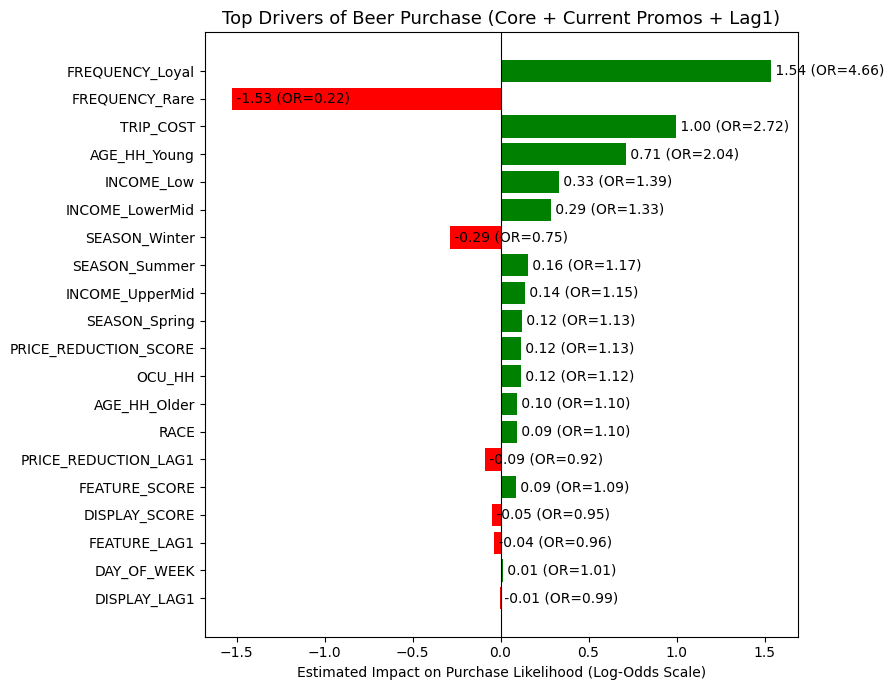

In [10]:
# Re-import after reset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Coefficients for Model 1 (from user's output)
coef_data_model2 = {
    "Variable": [
        "FREQUENCY_Loyal", "TRIP_COST", "AGE_HH_Young",
        "INCOME_Low", "INCOME_LowerMid", "SEASON_Summer",
        "INCOME_UpperMid", "SEASON_Spring", "PRICE_REDUCTION_SCORE",
        "OCU_HH", "AGE_HH_Older", "RACE",
        "FEATURE_SCORE", "DAY_OF_WEEK", "DISPLAY_LAG1",
        "FEATURE_LAG1", "DISPLAY_SCORE", "PRICE_REDUCTION_LAG1",
        "SEASON_Winter", "FREQUENCY_Rare"
    ],
    "Coef": [
        1.538659, 0.999266, 0.711303,
        0.331407, 0.288608, 0.157425,
        0.137633, 0.121303, 0.118525,
        0.116751, 0.095941, 0.094667,
        0.085404, 0.011392, -0.005739,
        -0.037621, -0.048241, -0.087300,
        -0.285807, -1.527462
    ]
}


coef_df1 = pd.DataFrame(coef_data_model2)
coef_df1["OddsRatio"] = np.exp(coef_df1["Coef"])

# Sort by absolute coefficient magnitude
coef_df1 = coef_df1.reindex(coef_df1["Coef"].abs().sort_values(ascending=True).index)

# Plot
plt.figure(figsize=(9,7))
bars = plt.barh(coef_df1["Variable"], coef_df1["Coef"], 
                color=(coef_df1["Coef"] > 0).map({True: "green", False: "red"}))
plt.axvline(0, color="black", linewidth=0.8)
plt.title("Top Drivers of Beer Purchase (Core + Current Promos + Lag1)", fontsize=13)
plt.xlabel("Estimated Impact on Purchase Likelihood (Log-Odds Scale)")

# Add labels: coef and odds ratio
for bar, coef, orr in zip(bars, coef_df1["Coef"], coef_df1["OddsRatio"]):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f" {coef:.2f} (OR={orr:.2f})", va='center')

plt.tight_layout()
plt.show()
